In [22]:
import numpy as np
import pydicom as dicom
import os
import matplotlib.pyplot as plt
from glob import glob
from skimage import morphology, measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from skimage.segmentation import slic, mark_boundaries

In [3]:
image_directory = "/home/pavic/Imagens/LIDC-IDRI-Incomplete/teste/*"
output_path = "/home/pavic/Imagens/NPY/"
path_to_images = glob(image_directory)
largest_stack = 0
patient_path = []

In [ ]:
for patient in path_to_images:
    subdirs = glob(patient + "/*")
    # 1st Branch
    first_subdir = glob(subdirs[0]+"/*")[0]
    first_len = len([name for name in os.listdir(first_subdir + "/")])
    # 2nd Branch
    second_subdir = glob(subdirs[-1] + "/*")[0]
    second_len = len([name for name in os.listdir(second_subdir + "/")])

    # If 1st longer then build structure from 1st data
    # If 2nd longer then build structure from 2nd data
    if first_len > second_len:
        patient_image_folder = first_subdir + "/*.dcm"
    else:
        patient_image_folder = second_subdir + "/*.dcm"
        
    patient_path.append(glob(patient_image_folder))

#### Escalas de Hounsfield - Relacionadas a radiografias, transformam os tons de cinza de imagens de radiografias em valores numéricos

In [36]:
#Função que carrega as imagens e armazena-as em uma lista 
def load_scan(path):
    slices = []
    for image in path:
        # Read in each image and construct 3d arrays
        ds = dicom.dcmread(image)
        slices.append(ds)
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
    print(len(slices))
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

for exam in patient_path:
    patient = load_scan(exam)
    id=patient[0].PatientID
    data = []
    for im in patient:
        data.append(im.SliceLocation)
    imgs = get_pixels_hu(patient)
    np.save(output_path + "full_images/fullimages_%s.npy" % (id), patient)
    np.save(output_path + "SliceLocation/SL_%s.npy" % (id), data)
    print("Patient "+id)

133
Patient LIDC-IDRI-1011
252
Patient LIDC-IDRI-1010
529
Patient LIDC-IDRI-1004


In [13]:
file_used="/home/pavic/Imagens/NPY/full_images/fullimages_LIDC-IDRI-0072.npy"
imgs_to_process = np.load(file_used) 

##### Padronize o valor do pixel subtraindo a média e dividindo pelo desvio padrão
##### Identifique o limiar apropriado criando dois grupos de KMeans comparando-se centrados em tecido mole / osso versus pulmão / ar.
##### Usando Erosão e dilatação, que tem o efeito líquido da remoção de recursos minúsculos como vasos pulmonares ou ruído
##### Identifique cada região distinta como rótulos de imagem separados (pense na varinha mágica no Photoshop)
##### Usando caixas delimitadoras para cada rótulo de imagem para identificar quais representam o pulmão e quais representam "tudo o mais"
##### Crie as máscaras para campos pulmonares.
##### Aplique a máscara na imagem original para apagar voxels fora dos campos pulmonares.

In [26]:
#Padronização dos valores dos pixels
def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Encontre o valor médio de pixel perto 
    # dos pulmões para renormalizar imagens desbotadas
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # Para melhorar a descoberta do limite, estou movendo o underflow e overflow no espectro de pixels
    img[img==max]=mean
    img[img==min]=mean
    #
    # Usando KMeans para separar o primeiro plano (tecido mole / osso) e fundo (pulmão / ar)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # Primeiro corroer os elementos mais finos, depois dilatar para incluir alguns dos pixels em torno do pulmão.  
    # Nós não queremos acidentalmente cortar o pulmão.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Etiquetas diferentes são exibidas em cores diferentes
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  Depois que apenas os pulmões são deixados, fazemos outra grande dilatação para preencher e retirar a máscara do pulmão
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    #mask = morphology.dilation(mask,np.ones([10,10])) # uma última dilatação

    par = mask*img
    
    _im = par*20
    segments = slic(_im, n_segments=100, compactness=10, sigma=1)
    label_image = segments * mask
    
    return label_image

In [16]:
def create_regions_lists(img):
    
    regions = []
    labels = np.unique(img)
    
    for i in labels:
        temp = np.zeros([512,512])
        temp = temp + np.where(img==i,1.0,0.0)
        reg = img*temp
        regions.append(reg)
    
    return regions

In [ ]:
teste = create

In [18]:
image_labels = []
for img in imgs_to_process:
    image_labels.append(make_lungmask(img))

In [21]:
np.unique(image_labels[162])

array([  0,  39,  41,  43,  44,  45,  46,  51,  52,  53,  54,  55,  57,
        58,  59,  62,  65,  66,  67,  68,  69,  70,  72,  73,  77,  79,
        80,  81,  82,  83,  84,  85,  88,  89,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 105, 106, 107, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 120, 121, 122, 123, 124, 125, 126, 128,
       129, 130, 131, 133, 134, 135, 136, 137, 138, 147, 148, 150])

In [19]:
regions = []
labels = np.unique(image_labels[162])
    
for i in labels:
    temp = np.zeros([512,512])
    temp = temp + np.where(image_labels[162]==i,1.0,0.0)
    reg = image_labels[162]*temp
    regions.append(reg)

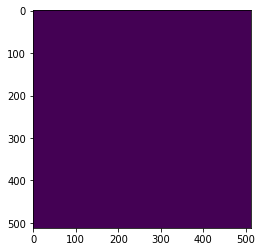

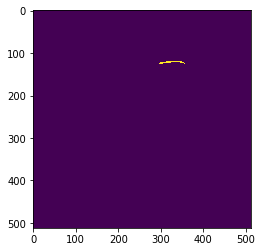

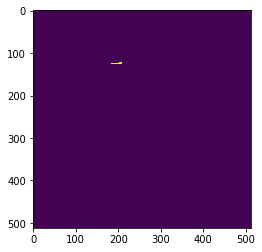

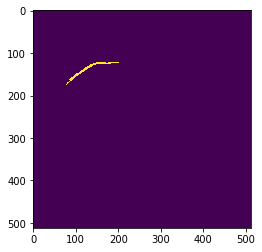

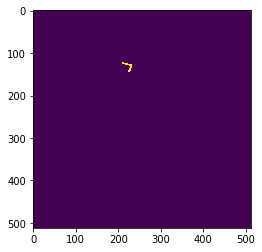

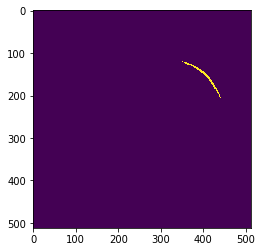

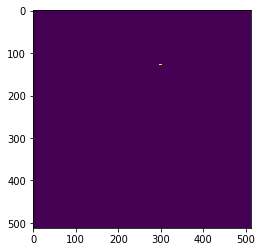

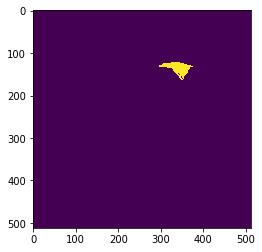

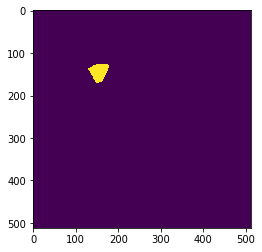

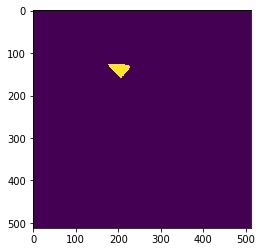

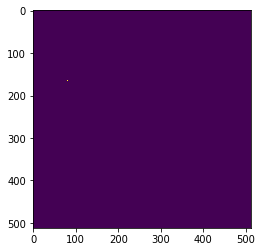

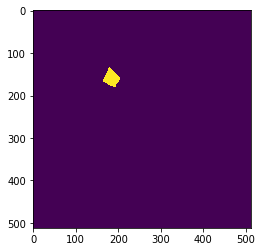

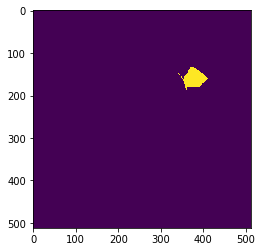

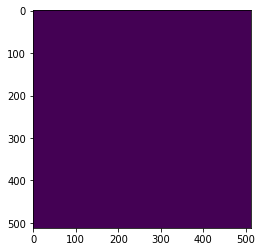

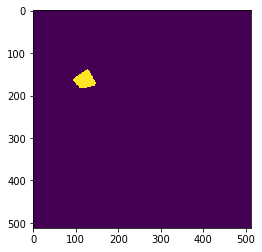

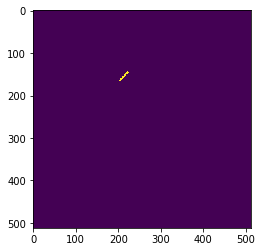

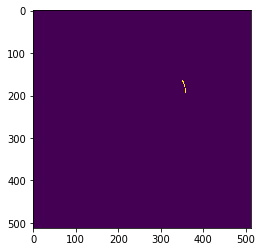

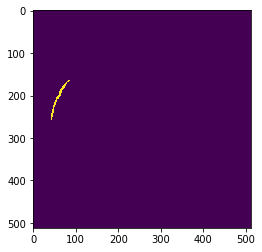

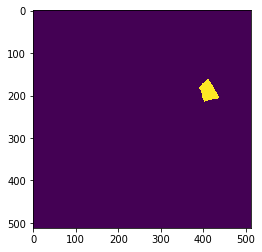

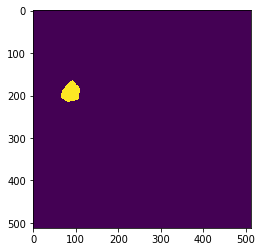

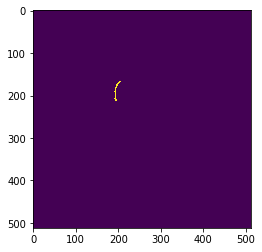

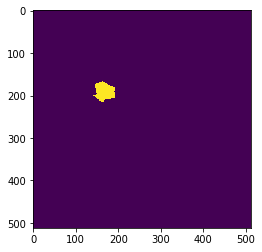

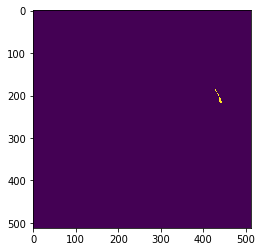

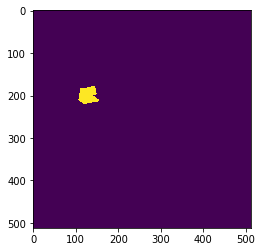

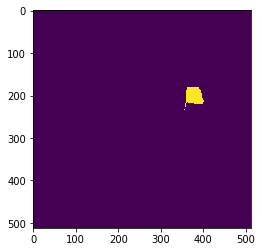

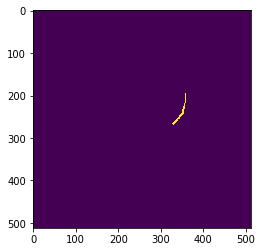

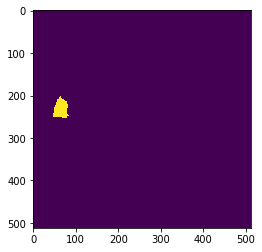

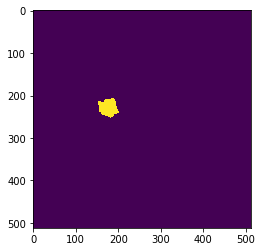

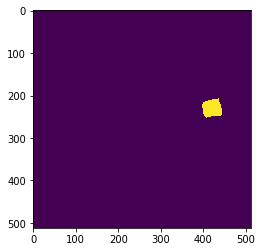

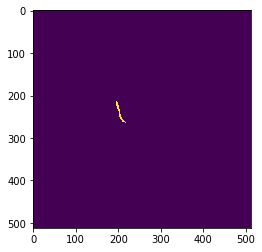

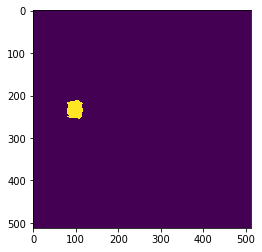

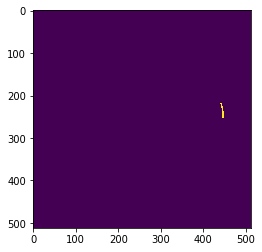

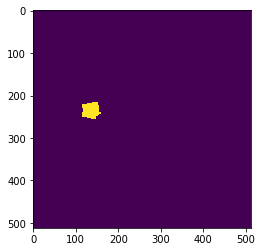

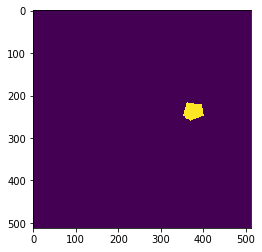

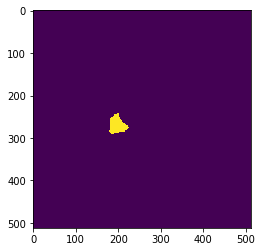

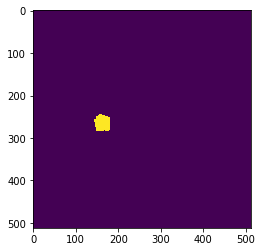

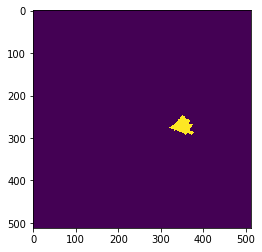

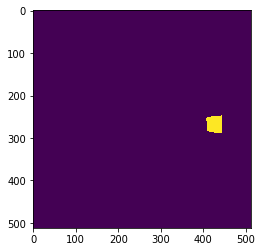

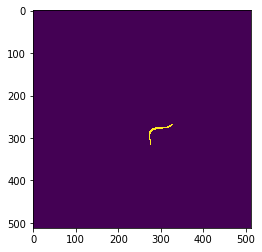

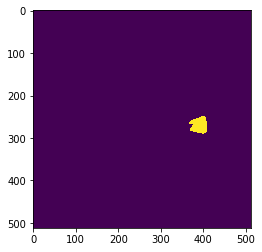

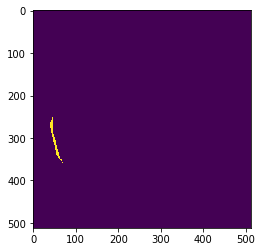

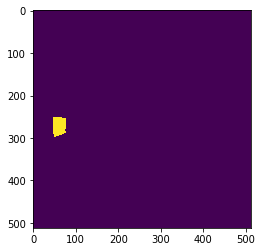

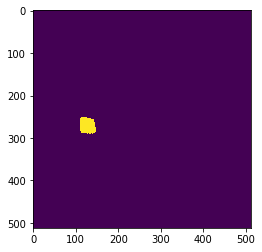

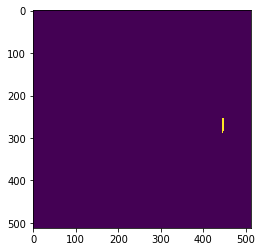

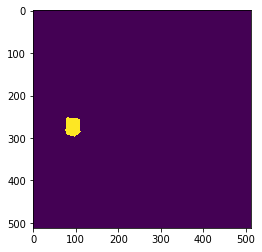

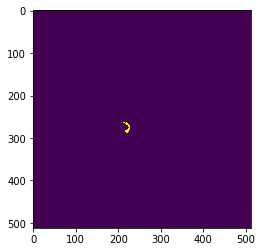

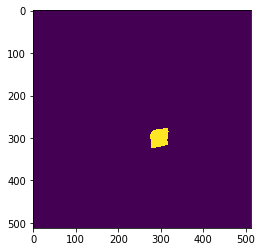

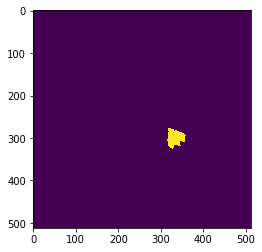

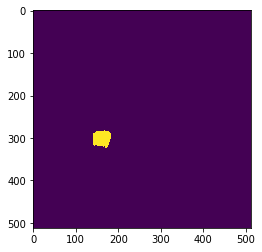

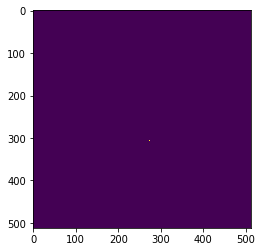

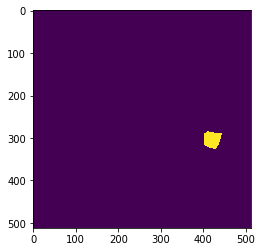

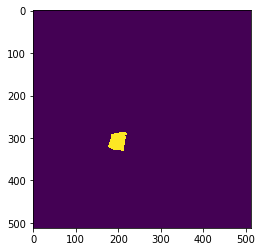

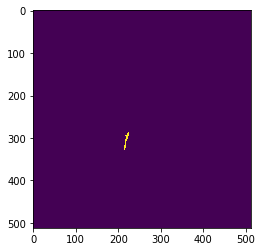

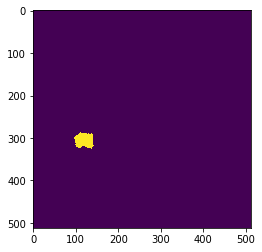

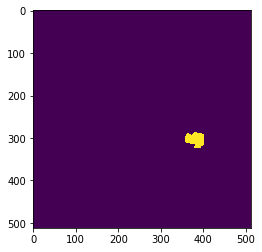

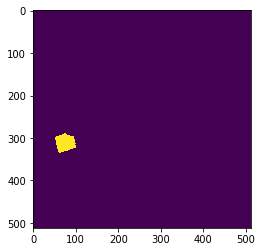

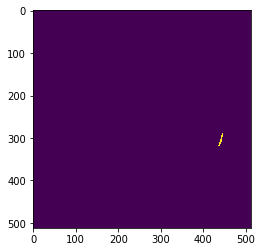

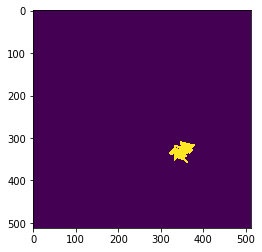

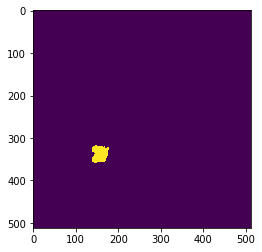

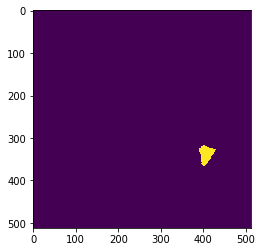

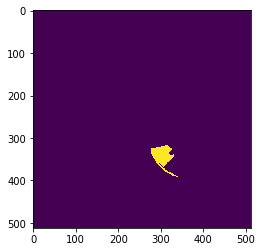

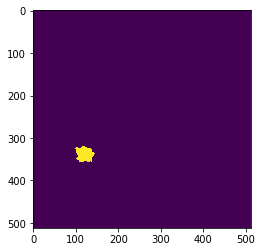

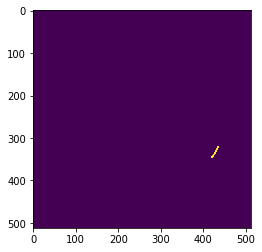

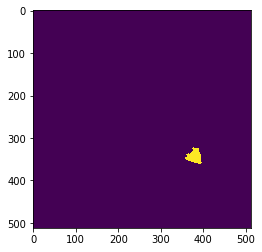

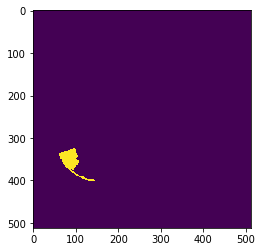

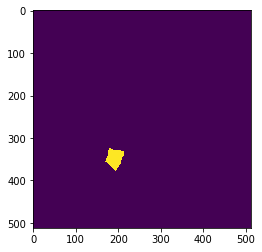

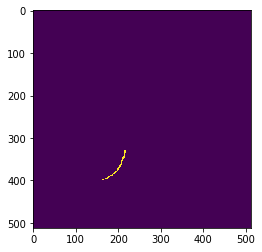

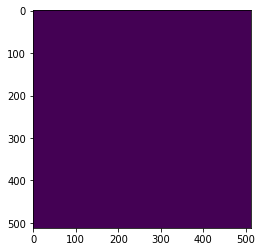

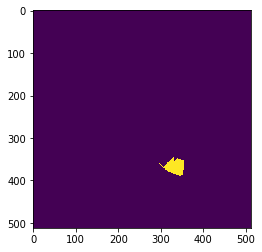

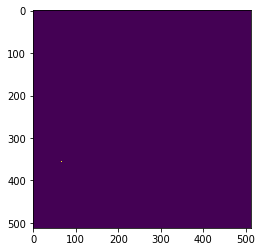

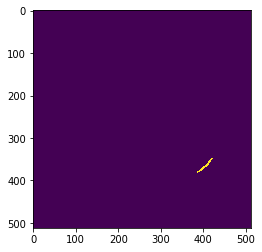

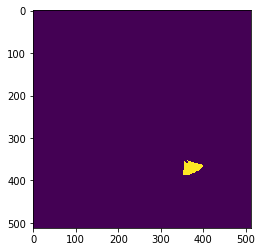

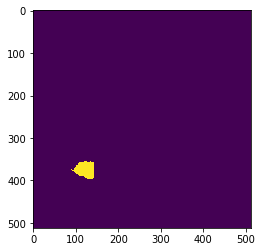

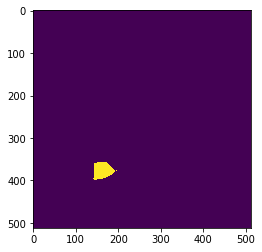

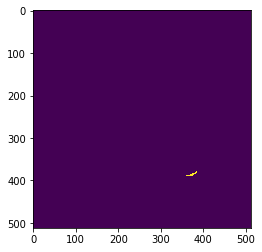

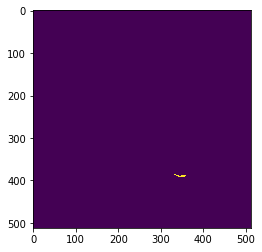

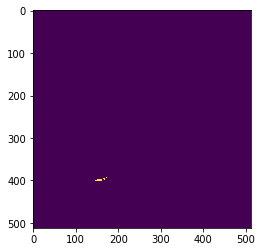

In [20]:
for reg in regions:
    plt.imshow(reg)
    plt.show()

In [ ]:
plt.imshow(image_labels[162])
plt.show()

In [ ]:
lung_regions_list = []
cont = 0
for img in image_labels:
    lung_regions_list.append([create_regions_lists(img), float(patient[cont].SliceLocation)])
    cont = cont + 1

In [ ]:
np.save(output_path + "maskedimages_%s.npy" % (id), masked_lung)

In [ ]:
img = imgs[162]

In [ ]:
teste = img*20

In [ ]:
segments = slic(teste, n_segments=200, compactness=10, sigma=1)

In [ ]:
plt.imshow(teste)
plt.show()

In [ ]:
reg_nod = img*regions[1]

In [ ]:
plt.imshow(reg_nod, cmap='gray')
plt.show()